In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import gen_batches
from sklearn.metrics import f1_score

import numpy as np
from tensor import Tensor
from activations_and_loss import sigmoid, cross_entropy_loss
from modules import ModuleTrainer, Module, Linear
from matplotlib import pyplot as plt

# Implementation details

Location of main components
- Tensor definitions in `tensor.py`
- Op gradients in `backward_ops.py`
- Backpropagation in `backprop.py`
- Finite difference gradient estimation in `finite_diff.py`
- Trainable modules, optimizer, and model trainer class in `modules.py`
- Activations and cross entropy loss in `activations_and_loss.py`

## Prepare data

Use digits dataset from sklearn, which contains 8x8 images of numbers. Preprocessing steps include
1. Split into train and test
2. Normalize features to range [0,1]
3. One hot encoding for labels
4. Preparing batches (no shuffling during training)

In [2]:
data = load_digits()

In [3]:
X_tr, X_te, Y_tr, Y_te = train_test_split(data["data"], data["target"], stratify=data["target"])

In [4]:
X_tr = X_tr / X_tr.max()
X_te = X_te / X_tr.max()

In [5]:
label_encoder = OneHotEncoder(sparse_output=False)
Y_tr_onehot = label_encoder.fit_transform(Y_tr.reshape((-1,1)))
Y_te_onehot = label_encoder.transform(Y_te.reshape((-1,1)))

In [6]:
assert len(Y_tr_onehot) == len(X_tr)
assert len(Y_te_onehot) == len(X_te)
train_data = [
    (X_tr[slice_], Y_tr_onehot[slice_]) for slice_ in gen_batches(len(X_tr), batch_size=64)
]
test_data = [
    (X_te[slice_], Y_te_onehot[slice_]) for slice_ in gen_batches(len(X_te), batch_size=64)
]

## Define model and trainer

Define class `DigitsClassifier`
1. Three FC layers and sigmoid activation between layers
2. Hidden sizes are 40 and 20
3. Trained with cross entropy loss

Define `DigitsTrainer`


In [7]:
class DigitsClassifier(Module):
    def __init__(self, num_classes=10, *args, **kwargs):
        super().__init__()

        self.l1 = Linear(64, 40)
        self.l2 = Linear(40, 20)
        self.l3 = Linear(20, num_classes)

    def __call__(self, x):
        x = sigmoid(self.l1(x))
        x = sigmoid(self.l2(x))
        x = self.l3(x)
        return x

    def loss(self, logits, y_true):
        loss = cross_entropy_loss(logits, y_true)
        return loss.mean()

    def score(self, logits, y_true):
        y_pred = logits.argmax()
        y_true = y_true.argmax()
        return f1_score(y_true.data, y_pred.data, average="micro")

    def predict(self, x):
        logits = self(x)
        return logits.argmax()


In [8]:
class DigitsTrainer(ModuleTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def make_model(self):
        self.model = DigitsClassifier()

## Training

In [9]:
trainer = DigitsTrainer(num_epochs=300, learning_rate=1e-3)
trainer.fit(train_data=train_data, test_data=test_data)

Epoch 0, Train Loss: 6.4494, Train F1 Score: 0.1139, Test Loss: 6.1054, Test F1 Score: 0.0879
Epoch 1, Train Loss: 6.3522, Train F1 Score: 0.1110, Test Loss: 5.9949, Test F1 Score: 0.1191
Epoch 2, Train Loss: 6.3041, Train F1 Score: 0.1110, Test Loss: 5.9135, Test F1 Score: 0.1895
Epoch 3, Train Loss: 6.2751, Train F1 Score: 0.1117, Test Loss: 5.8466, Test F1 Score: 0.3281
Epoch 4, Train Loss: 6.2496, Train F1 Score: 0.1868, Test Loss: 5.7908, Test F1 Score: 0.5273
Epoch 5, Train Loss: 6.2200, Train F1 Score: 0.2834, Test Loss: 5.7342, Test F1 Score: 0.5781
Epoch 6, Train Loss: 6.1836, Train F1 Score: 0.4233, Test Loss: 5.6804, Test F1 Score: 0.5703
Epoch 7, Train Loss: 6.1397, Train F1 Score: 0.5575, Test Loss: 5.6370, Test F1 Score: 0.5781
Epoch 8, Train Loss: 6.0885, Train F1 Score: 0.6326, Test Loss: 5.5902, Test F1 Score: 0.5859
Epoch 9, Train Loss: 6.0318, Train F1 Score: 0.6894, Test Loss: 5.5358, Test F1 Score: 0.6191
Epoch 10, Train Loss: 5.9716, Train F1 Score: 0.7223, Test L

# Check results

Predicted: 6, Correct: 6


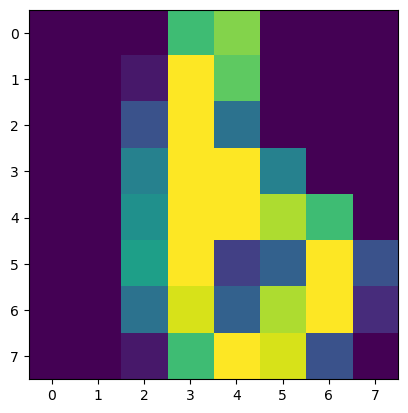

Predicted: 4, Correct: 4


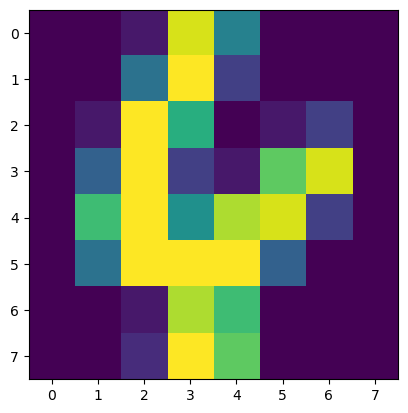

Predicted: 3, Correct: 3


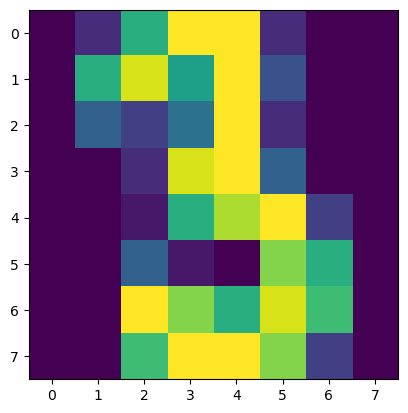

Predicted: 6, Correct: 6


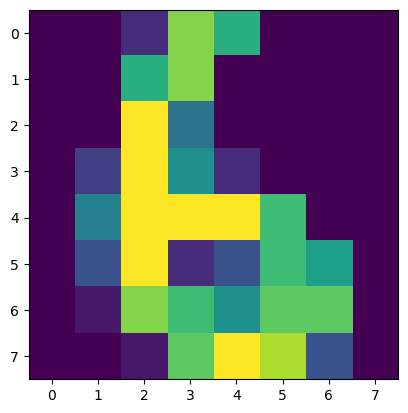

Predicted: 7, Correct: 7


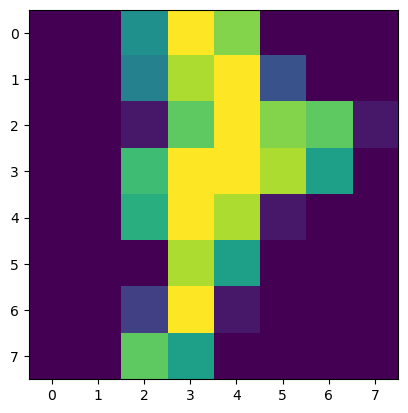

In [10]:
num_images = 5
test_images, test_labels = test_data[0][0][:num_images], test_data[0][1][:num_images]
for image, label in zip(test_images, test_labels):
    as_batch = Tensor(image.reshape(1,-1))
    pred = trainer.model.predict(as_batch)[0].item()
    print(f"Predicted: {pred}, Correct: {np.argmax(label)}")
    plt.imshow(image.reshape(8,8), interpolation='nearest')
    plt.show()

## Run pytest

In [11]:
!pytest .

============================= test session starts ==============================
platform darwin -- Python 3.8.16, pytest-7.3.0, pluggy-1.0.0
rootdir: /Users/LTV/dev/autograd
collected 6 items                                                              

tests/test_grads.py ....                                                 [ 66%]
tests/test_model_trainer.py .                                            [ 83%]
tests/test_ops.py .                                                      [100%]

=============================== warnings summary ===============================
tests/test_ops.py::test_ops
  /Users/LTV/dev/autograd/tests/test_ops.py:39: RuntimeWarning: invalid value encountered in log
    Tensor.log: {"ans": [Tensor(np.log(a.data))]},

tests/test_ops.py::test_ops
  /Users/LTV/dev/autograd/tensor.py:71: RuntimeWarning: invalid value encountered in log
    new_tensor = Tensor(np_op(*np_args, **kwargs))

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
====

## Run mypy

In [12]:
!mypy activations_and_loss.py backprop.py backward_ops.py finite_diff.py modules.py tensor.py

Success: no issues found in 6 source files


## Examples of catching incorrect types

In [13]:
!mypy mypy_errors.py

mypy_errors.py:7: error: Argument 1 to "Tensor" has incompatible type "int"; expected "Union[ndarray[Any, dtype[signedinteger[_32Bit]]], ndarray[Any, dtype[signedinteger[_64Bit]]], ndarray[Any, dtype[bool_]], ndarray[Any, dtype[floating[_32Bit]]], ndarray[Any, dtype[floating[_64Bit]]]]"  [arg-type]
mypy_errors.py:8: error: Argument 1 to "Tensor" has incompatible type "float"; expected "Union[ndarray[Any, dtype[signedinteger[_32Bit]]], ndarray[Any, dtype[signedinteger[_64Bit]]], ndarray[Any, dtype[bool_]], ndarray[Any, dtype[floating[_32Bit]]], ndarray[Any, dtype[floating[_64Bit]]]]"  [arg-type]
mypy_errors.py:9: error: Argument 1 to "Tensor" has incompatible type "bool"; expected "Union[ndarray[Any, dtype[signedinteger[_32Bit]]], ndarray[Any, dtype[signedinteger[_64Bit]]], ndarray[Any, dtype[bool_]], ndarray[Any, dtype[floating[_32Bit]]], ndarray[Any, dtype[floating[_64Bit]]]]"  [arg-type]
mypy_errors.py:10: error: Argument 1 to "Tensor" has incompatible type "ndarray[Any, dtype[object

## Check gradients

In [14]:
from backprop import grad as bp_grad
from finite_diff import finite_difference as fd_grad
from tensor import make_parameter, no_grad


def two_layers_nn(x, y, weights1, bias1, weights2, bias2):
    x = sigmoid(x @ weights1 + bias1)
    logits = x @ weights2 + bias2
    loss = cross_entropy_loss(logits, y)
    return loss.sum()

one_image = Tensor(np.reshape(train_data[0][0][0], (1, -1)))
one_label = Tensor(np.reshape(train_data[0][1][0], (1, -1)))
weights1 = make_parameter(np.random.normal(size=(one_image.shape[1], 20)))
bias1 = make_parameter(np.random.normal(size=(1, 20)))
weights2 = make_parameter(np.random.normal(size=(20, one_label.shape[1])))
bias2 = make_parameter(np.random.normal(size=(1, one_label.shape[1])))

with no_grad():
    fd_grads = fd_grad(1e-2, two_layers_nn, one_image, one_label, weights1, bias1, weights2, bias2)
bp_grads = bp_grad(two_layers_nn, one_image, one_label, weights1, bias1, weights2, bias2)


In [15]:
assert len(fd_grads) == len(bp_grads)
for ind, (fd_grad, bp_grad) in enumerate(zip(fd_grads, bp_grads)):
    if fd_grad is None:
        assert bp_grad is None
        print(f"No gradients for argument {ind}")
        continue

    non_zero_mask = fd_grad != 0.
    fd_grad_ = fd_grad[non_zero_mask]
    bp_grad_ = bp_grad[non_zero_mask]

    diff = np.abs(fd_grad_ - bp_grad_) / np.abs(fd_grad_)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"For argument {ind} maximum diff is {max_diff*100:.5f}%, average diff {mean_diff*100:.5f}%")

No gradients for argument 0
No gradients for argument 1
For argument 2 maximum diff is 0.01151%, average diff 0.00090%
For argument 3 maximum diff is 0.01151%, average diff 0.00210%
For argument 4 maximum diff is 0.00166%, average diff 0.00046%
For argument 5 maximum diff is 0.00167%, average diff 0.00118%
